In [1]:
import sys
sys.path.append('..')

In [2]:
from minbpe import BasicTokenizer

tokenizer = BasicTokenizer()
tokenizer.load(model_file="../Data/tokenizer/my_tokenizer.model")


def get_vocab_size(tokenizer: BasicTokenizer) -> int:
    vocab = tokenizer.vocab
    special_tokens = tokenizer.special_tokens

    return len(vocab) + len(special_tokens)

In [3]:
import torch
torch.manual_seed(3647)

In [4]:
from transformer.model import GPTLanguageModel

block_size = 256
n_embd =512
n_head = 4
n_layer = 1
dropout = 0.2
batch_size = 32
vocab_size = get_vocab_size(tokenizer)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = GPTLanguageModel(
    vocab_size=vocab_size,
    block_size=block_size,
    n_embd=n_embd,
    n_head=n_head,
    n_layer=n_layer,
    dropout=dropout,
    device=device
).to(device)
model = torch.compile(model)

print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

4.342794 M parameters


In [5]:
device

'cuda'

In [6]:
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.backends.cudnn.version())
print(torch.cuda.is_available())


2.7.1+cu128
12.8
90701
True


In [7]:
import numpy as np

# load npy instead of txt
recipes = np.load("recipes_cleaned.npy", allow_pickle=True)
text_sequence = "\n".join(recipes)

encoded_text_sequence = tokenizer.encode(text_sequence)
len(encoded_text_sequence)

1760

In [47]:
# with open("../Data/combined_text.txt", "r") as f:
#     text_sequence = f.read()

# encoded_text_sequence = tokenizer.encode(text_sequence)
# len(encoded_text_sequence)
# with open("../Data/combined_text.txt", "r", encoding='utf-8') as f:
#     text_sequence = f.read()

# encoded_text_sequence = tokenizer.encode(text_sequence)
# len(encoded_text_sequence)

In [8]:
data = torch.tensor(encoded_text_sequence, dtype=torch.long)
split_index = int(0.5*len(data))
train_data = data[:split_index]
val_data = data[split_index:]

In [9]:
from typing import Tuple
from torch.utils.data import Dataset, DataLoader


class TextDataset(Dataset):
    def __init__(self, data: torch.Tensor, block_size: int) -> None:
        self.data = data
        self.block_size = block_size

    def __len__(self) -> int:
        return len(self.data) - self.block_size

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        x = self.data[index:index + self.block_size]
        y = self.data[index + 1:index + self.block_size + 1]
        return x, y


def get_dataloaders(
        train_data: torch.Tensor,
        val_data: torch.Tensor,
        block_size: int,
        batch_size: int,
        device: torch.device
) -> Tuple[DataLoader, DataLoader]:
    train_dataset = TextDataset(train_data.to(device), block_size)
    val_dataset = TextDataset(val_data.to(device), block_size)

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
    )

    return train_loader, val_loader

In [11]:
train_loader, val_loader = get_dataloaders(
    train_data=train_data,
    val_data=val_data,
    block_size=block_size,
    batch_size=batch_size,
    device=device
)
x, y = next(iter(train_loader))
x.shape, y.shape

(torch.Size([32, 256]), torch.Size([32, 256]))

In [12]:
from typing import Dict


@torch.no_grad()
def estimate_loss(
    model: torch.nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    eval_iters: int
) -> Dict[str, float]:
    output = {}
    model.eval()

    for split, loader in [('train', train_loader), ('val', val_loader)]:
        losses = torch.zeros(eval_iters)
        for i, (x, y) in enumerate(loader):
            if i >= eval_iters:
                break
            with torch.no_grad():
                _, loss = model(x, y)
            losses[i] = loss.item()
        output[split] = losses.mean().item()

    model.train()
    return output

In [13]:
def save_checkpoint(
    model: GPTLanguageModel,
    optimizer: torch.optim.Optimizer,
    epoch: int,
    loss: float,
    file_path: str = "checkpoint.pth"
) -> None:
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, file_path)

In [14]:
import os
import warnings

# --- Disable Triton checks ---
os.environ["TORCHINDUCTOR_DISABLE_TRITON"] = "1"

# --- Suppress TorchDynamo / Inductor warnings ---
warnings.filterwarnings("ignore", category=UserWarning)

# Optional: fully disable TorchDynamo verbose logging
import torch._dynamo as dynamo
dynamo.reset()
dynamo.config.verbose = 0
dynamo.config.suppress_errors = True


In [15]:
print(type(train_data), type(val_data))
print(len(train_data))
print(len(val_data))


<class 'torch.Tensor'> <class 'torch.Tensor'>
880
880


In [16]:
print(len(train_data), len(val_data))


880 880


In [17]:
max_iters = 20
eval_interval =20
eval_iters = 10
learning_rate = 1e-4

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
train_loader, val_loader = get_dataloaders(
    train_data=train_data,
    val_data=val_data,
    block_size=block_size,
    batch_size=batch_size,
    device=device
)

train_losses = []
val_losses = []

for iteration in range(max_iters):
    for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
        # Evaluation
        if batch_idx % eval_interval == 0 or batch_idx == len(train_loader) - 1:
            losses = estimate_loss(
                model=model,
                train_loader=train_loader,
                val_loader=val_loader,
                eval_iters=min(eval_iters, len(val_loader))
            )
            train_losses.append(losses['train'])
            val_losses.append(losses['val'])

            print(
                f"iteration {iteration} / step {batch_idx}: "
                f"train loss {losses['train']:.4f}, "
                f"val loss {losses['val']:.4f}"
            )

        # Training step
        logits, loss = model(x_batch, y_batch)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    # Save checkpoint
    save_checkpoint(
        model=model,
        optimizer=optimizer,
        epoch=iteration,
        loss=loss.item(),
        file_path=f"../Data/pre_training/run_1/checkpoint_{iteration}.pth"
    )

W0903 20:35:55.705629 9792 site-packages\torch\_inductor\utils.py:1250] [0/0] Not enough SMs to use max_autotune_gemm mode
W0903 20:35:56.057777 9792 site-packages\torch\_dynamo\convert_frame.py:1280] WON'T CONVERT forward d:\WORK space\LLm\NoteBook\..\transformer\model.py line 129 
W0903 20:35:56.057777 9792 site-packages\torch\_dynamo\convert_frame.py:1280] due to: 
W0903 20:35:56.057777 9792 site-packages\torch\_dynamo\convert_frame.py:1280] Traceback (most recent call last):
W0903 20:35:56.057777 9792 site-packages\torch\_dynamo\convert_frame.py:1280]   File "c:\Users\Altai\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\_dynamo\convert_frame.py", line 1213, in __call__
W0903 20:35:56.057777 9792 site-packages\torch\_dynamo\convert_frame.py:1280]     result = self._inner_convert(
W0903 20:35:56.057777 9792 site-packages\torch\_dynamo\convert_frame.py:1280]   File "c:\Users\Altai\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\_dynamo\convert_frame.py

iteration 0 / step 0: train loss 7.0614, val loss 7.0625
iteration 0 / step 19: train loss 5.1625, val loss 6.8327
iteration 1 / step 0: train loss 5.0589, val loss 6.8351
iteration 1 / step 19: train loss 3.3115, val loss 6.8940
iteration 2 / step 0: train loss 3.2117, val loss 6.8980
iteration 2 / step 19: train loss 1.8665, val loss 7.0578
iteration 3 / step 0: train loss 1.8008, val loss 7.0715
iteration 3 / step 19: train loss 1.0828, val loss 7.3667
iteration 4 / step 0: train loss 1.0598, val loss 7.3811
iteration 4 / step 19: train loss 0.7338, val loss 7.6708
iteration 5 / step 0: train loss 0.6870, val loss 7.6828
iteration 5 / step 19: train loss 0.4665, val loss 7.9184
iteration 6 / step 0: train loss 0.4679, val loss 7.9271
iteration 6 / step 19: train loss 0.3306, val loss 8.1142
iteration 7 / step 0: train loss 0.3120, val loss 8.1209
iteration 7 / step 19: train loss 0.2316, val loss 8.2705
iteration 8 / step 0: train loss 0.2256, val loss 8.2798
iteration 8 / step 19: 

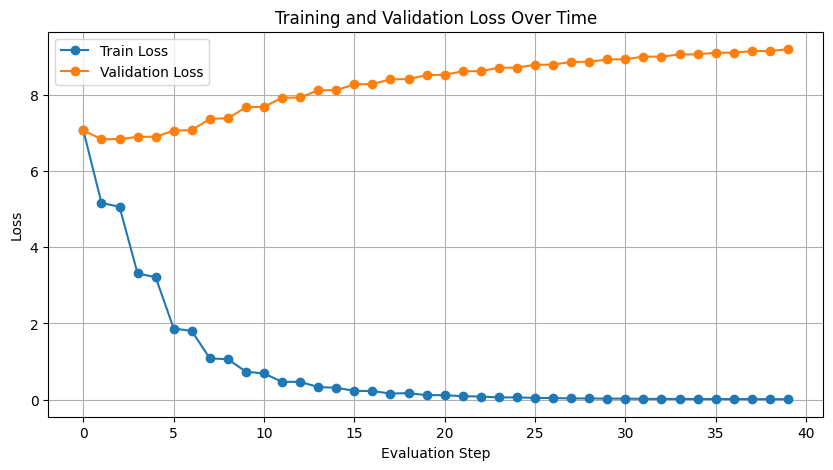

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(val_losses, label="Validation Loss", marker='o')
plt.xlabel("Evaluation Step")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Time")
plt.legend()
plt.grid()
plt.show()

In [23]:
input_tokens = tokenizer.encode("Pancakes:  ")
input_tokens = torch.tensor(
    input_tokens, dtype=torch.long).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output = model.generate(input_tokens=input_tokens, max_new_tokens=26)

print(tokenizer.decode(output[0].tolist()))

Pancakes:  on a hot pan, cook until crisp. Serve with chutney and sambar.
  Parella and serve warm.
  Scrambled Eggs: Whisk eggs with milk, cook sl
